In [1]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV


In [2]:
vt_model = xgboost.XGBRegressor()
vt_model.load_model('../checkpoint/vt_xgboost_model.model')

In [3]:
full_df = pd.read_csv('../data_full/full_dataset.csv')
full_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,9.424700e-15,10,5,0
1,0.1,-19.8,9.424700e-15,10,5,0
2,0.1,-19.6,9.424700e-15,10,5,0
3,0.1,-19.4,9.424700e-15,10,5,0
4,0.1,-19.2,9.424700e-15,10,5,0


In [4]:
full_df['Vt'] = full_df.apply(lambda row : vt_model.predict([row[['W','L', 'T','Vds']].to_numpy()])[0], axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt
0,0.1,-20.0,9.424700e-15,10,5,0,0.999991
1,0.1,-19.8,9.424700e-15,10,5,0,0.999991
2,0.1,-19.6,9.424700e-15,10,5,0,0.999991
3,0.1,-19.4,9.424700e-15,10,5,0,0.999991
4,0.1,-19.2,9.424700e-15,10,5,0,0.999991


In [5]:
def calculate_drain_equation(width, length, vgs, vds, vt):
    right_term = (vgs-vt)*vds - 1/2*(vds**2)
    return (width/length)*right_term

In [6]:
full_df['Drain'] = full_df.apply(lambda row : calculate_drain_equation(row['W'], row['L'], row['Vgs'], row['Vds'], row['Vt']), axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt,Drain
0,0.1,-20.0,9.424700e-15,10,5,0,0.999991,-4.209998
1,0.1,-19.8,9.424700e-15,10,5,0,0.999991,-4.169998
2,0.1,-19.6,9.424700e-15,10,5,0,0.999991,-4.129998
3,0.1,-19.4,9.424700e-15,10,5,0,0.999991,-4.089998
4,0.1,-19.2,9.424700e-15,10,5,0,0.999991,-4.049998


In [7]:
class_0_df = full_df.query('Vgs<0')
class_1_df = full_df.query('Vgs>=0')

In [8]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_0_y = full_df[['Ids']].to_numpy()
class_0_X = full_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
class_0_X_train, class_0_X_test, class_0_y_train, class_0_y_test = train_test_split(class_0_X, class_0_y, test_size=0.2)
class_0_xgb_model = xgboost.XGBRegressor()
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:linear'],
                 'random_state':[2]}

class_0_xgb_grid = GridSearchCV(class_0_xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_0_X_train), len(class_0_X_test))
class_0_xgb_grid.fit(class_0_X_train,class_0_y_train)
print(class_0_xgb_grid.best_score_)
print(class_0_xgb_grid.best_params_)

69465 17367
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[14:54:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:39] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:54:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:39] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

In [9]:
# xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=5, min_child_weight=4, n_estimators=500, nthread=4, objective='reg:linear', silent=1, subsample=0.7)
# xgb_model = xgb_grid.best_estimator_
class_0_xgb_model.fit(class_0_X_train, class_0_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

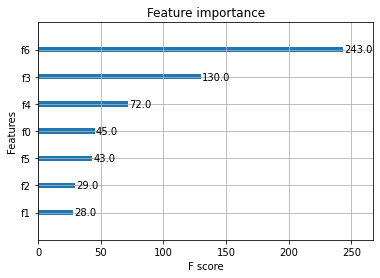

In [10]:
xgboost.plot_importance(class_0_xgb_model)

In [11]:
predictions = class_0_xgb_model.predict(class_0_X_test)
predictions

array([ 1.6018789e-06,  2.6485336e-06, -7.7042432e-07, ...,
       -7.7042432e-07,  2.1736209e-04,  3.5611645e-04], dtype=float32)

In [12]:
class_0_y_test.flatten()

array([7.6667e-13, 2.6486e-12, 3.3465e-14, ..., 3.3474e-14, 1.7399e-04,
       2.9775e-04])

In [13]:
r_sq = class_0_xgb_model.score(class_0_X_train, class_0_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_0_y_test))

0.9978836700960352
0.9974583778226647


In [14]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = torch.log(torch.abs(y_hat)+eps)
    log_abs_y = torch.log(torch.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = y_hat.size(dim=0)
    return torch.sqrt((1/len_delta)*torch.sum((log_abs_delta/(log_abs_y+eps))**2)) + torch.sqrt((1/len_delta)*torch.sum((delta/(y+eps))**2))

In [15]:
predictions = torch.tensor(class_0_xgb_model.predict(class_0_X_test))
actuals = torch.tensor(class_0_y_test.flatten())
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)
    

tensor(297.9383, dtype=torch.float64)


In [16]:
class_0_xgb_model.save_model('../checkpoint/classified_with_vt_xgboost_model_class_0.model')

In [19]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_1_y = full_df[['Ids']].to_numpy()
class_1_X = full_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(class_1_X, class_1_y, test_size=0.2)
class_1_xgb_model = xgboost.XGBRegressor()
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:linear'],
                 'random_state':[2]}

class_1_xgb_grid = GridSearchCV(class_1_xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_1_X_train), len(class_1_X_test))
class_1_xgb_grid.fit(class_1_X_train,class_1_y_train)
print(class_1_xgb_grid.best_score_)
print(class_1_xgb_grid.best_params_)

69465 17367
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[14:59:32] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:32] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:59:32] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:32] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

In [20]:
class_1_xgb_model.fit(class_1_X_train, class_1_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

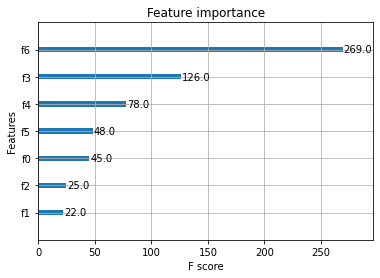

In [21]:
xgboost.plot_importance(class_1_xgb_model)

In [22]:
predictions = class_1_xgb_model.predict(class_1_X_test)
predictions

array([-5.2692923e-07,  2.4976667e-05,  2.5750684e-05, ...,
        6.4539904e-06,  1.3671145e-04, -3.8435151e-06], dtype=float32)

In [23]:
class_1_y_test.flatten()

array([2.6485e-11, 2.1680e-05, 1.4071e-05, ..., 2.6485e-10, 1.3791e-04,
       1.9123e-14])

In [24]:
r_sq = class_1_xgb_model.score(class_1_X_train, class_1_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_1_y_test))

0.9976786331741464
0.9971810281093668


In [25]:
predictions = torch.tensor(class_1_xgb_model.predict(class_1_X_test))
actuals = torch.tensor(class_1_y_test.flatten())
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)

tensor(320.4427, dtype=torch.float64)


In [26]:
class_1_xgb_model.save_model('../checkpoint/classified_with_vt_xgboost_model_class_1.model')